In [1]:
import pathlib as pl

import flopy
import matplotlib.pyplot as plt
import xarray as xa
import xugrid as xu

# Load the base watershed model

We will use the base watershed model to demonstrate MODFLOW NetCDF input functionality.  

In [2]:
name = "watershed"
sim = flopy.mf6.MFSimulation.load(
    sim_name=name, sim_ws=pl.Path("../../data/watershed/")
)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package drn...
    loading package drn...
    loading package oc...
  loading solution package model...


# Modify the model to export ascii input arrays to NetCDF

Define the `export_netcdf` variable in the groundwater flow model `name_file` and set to `structured` for this example. We also need to specifically export array input per package.  In this example we will do this for the DIS package.

In [3]:
gwf = sim.get_model()

In [4]:
gwf.export_netcdf = "structured"
gwf.dis.export_array_netcdf = True

# Write the model files and run the model in validate mode

In [5]:
ws = pl.Path("temp/structured")
sim.set_sim_path(ws)

In [6]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package model...
  writing model model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package river...
    writing package gwd...
    writing package oc...


In [7]:
cargs = ["--mode", "validate"]
sim.run_simulation(cargs=cargs)

FloPy is using the following executable to run the model: ../../../../../../usgs/modflow6/bin/mf6

mf6: MODFLOW 6 simulation mode VALIDATE. Model input will be checked for all
stress periods but the matrix equations will not be assembled or solved.


                               MODFLOW 6 EXTENDED
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 05/23/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Aug 27 2024 10:04:53 with GCC version 11.4.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided o

(True, [])

# Load the structured NetCDF file with `xarray` and visualize botm layers 1 and 5

In [8]:
nc_ds = xa.open_dataset(ws / "model.nc")

In [9]:
nc_ds

<xarray.Dataset> Size: 267kB
Dimensions:      (z: 5, y: 41, bnd: 2, x: 73)
Coordinates:
  * z            (z) float64 40B 1.0 2.0 3.0 4.0 5.0
  * y            (y) float64 328B 1.012e+05 9.875e+04 ... 3.75e+03 1.25e+03
  * x            (x) float64 584B 1.25e+03 3.75e+03 ... 1.788e+05 1.812e+05
Dimensions without coordinates: bnd
Data variables:
    y_bnds       (y, bnd) float64 656B ...
    x_bnds       (x, bnd) float64 1kB ...
    dis_delr     (x) float64 584B ...
    dis_delc     (y) float64 328B ...
    dis_top      (y, x) float64 24kB ...
    dis_botm     (z, y, x) float64 120kB ...
    dis_idomain  (z, y, x) float64 120kB ...
Attributes:
    title:           MODEL hydraulic head
    source:          MODFLOW 6 6.6.0.dev0 (preliminary) 05/23/2024
    modflow6_grid:   STRUCTURED
    modflow6_model:  MODEL: MODFLOW 6 Groundwater Flow (GWF) model
    history:         first created 2024/8/28 9:58:8.622
    Conventions:     CF-1.11

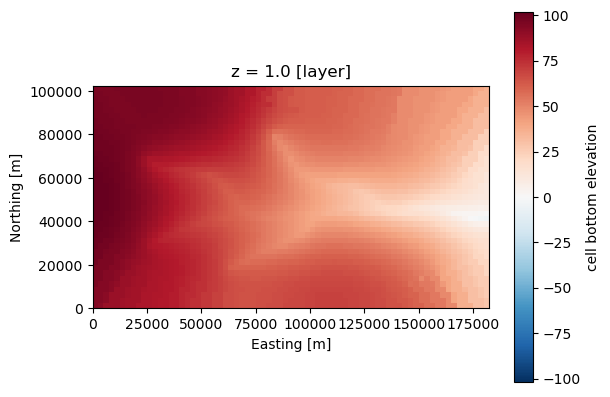

In [10]:
nc_ds["dis_botm"].isel(z=0).plot()
plt.gca().set_aspect(1.0)
plt.show(block=False)

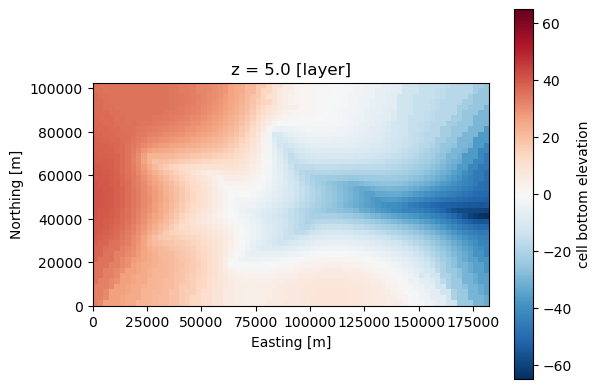

In [11]:
nc_ds["dis_botm"].isel(z=4).plot()
plt.gca().set_aspect(1.0)
plt.show(block=False)

# Deactivate NetCDF export and activate NetCDF import.

In [12]:
# set simulation start_date_time
sim.tdis.start_date_time = "1980-01-01"
gwf.export_netcdf = None
gwf.nc_filerecord = "model.nc"

# Write the simulation and the overwrite the DIS package to specify gridded arrays should be read from NetCDF.

In [13]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package model...
  writing model model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package river...
    writing package gwd...
    writing package oc...


In [14]:
with open(ws / "model.dis", "w") as f:
    f.write("BEGIN options\n")
    f.write("  XORIGIN       0.00000000\n")
    f.write("  YORIGIN       0.00000000\n")
    f.write("END options\n\n")
    f.write("BEGIN dimensions\n")
    f.write("  NLAY  5\n")
    f.write("  NROW  41\n")
    f.write("  NCOL  73\n")
    f.write("END dimensions\n\n")
    f.write("BEGIN griddata\n")
    f.write("  delr NETCDF\n")
    f.write("  delc NETCDF\n")
    f.write("  top NETCDF\n")
    f.write("  botm NETCDF\n")
    f.write("  idomain NETCDF\n")
    f.write("END griddata\n\n")

# Run the simulation.

In [15]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../usgs/modflow6/bin/mf6
                               MODFLOW 6 EXTENDED
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 05/23/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Aug 27 2024 10:04:53 with GCC version 11.4.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
use o

(True, [])

# Update model to export input arrays to `ugrid` NetCDF

Set the `export_netcdf` variable in the groundwater flow model `name_file` to `ugrid` to export input arrays as mesh NetCDF output. Deactive NetCDF as input.  Turn off DIS array export and turn on IC array export.

In [16]:
gwf.name_file.export_netcdf = "ugrid"
gwf.nc_filerecord = None
gwf.dis.export_array_netcdf = False
gwf.ic.export_array_netcdf = True

# Write the model files and run the model in validate mode

In [17]:
ws = pl.Path("temp/mesh")
sim.set_sim_path(ws)

In [18]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package model...
  writing model model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package river...
    writing package gwd...
    writing package oc...


In [19]:
cargs = ["--mode", "validate"]
sim.run_simulation(cargs=cargs)

FloPy is using the following executable to run the model: ../../../../../../usgs/modflow6/bin/mf6

mf6: MODFLOW 6 simulation mode VALIDATE. Model input will be checked for all
stress periods but the matrix equations will not be assembled or solved.


                               MODFLOW 6 EXTENDED
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 05/23/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Aug 27 2024 10:04:53 with GCC version 11.4.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided o

(True, [])

# Load the mesh NetCDF file with `xugrid` and visualize `strt` layer 1

In [20]:
nc_ds = xu.open_dataset(ws / "model.nc")

In [21]:
nc_ds

<xarray.Dataset> Size: 458kB
Dimensions:          (nmesh_node: 3108, nmesh_face: 2993,
                      max_nmesh_face_nodes: 4)
Coordinates:
  * nmesh_face       (nmesh_face) int64 24kB 0 1 2 3 4 ... 2989 2990 2991 2992
  * nmesh_node       (nmesh_node) int64 25kB 0 1 2 3 4 ... 3104 3105 3106 3107
Dimensions without coordinates: max_nmesh_face_nodes
Data variables:
    mesh_node_x      (nmesh_node) float64 25kB ...
    mesh_node_y      (nmesh_node) float64 25kB ...
    mesh_face_x      (nmesh_face) float64 24kB ...
    mesh_face_xbnds  (nmesh_face, max_nmesh_face_nodes) float64 96kB ...
    mesh_face_y      (nmesh_face) float64 24kB ...
    mesh_face_ybnds  (nmesh_face, max_nmesh_face_nodes) float64 96kB ...
    ic_strt_l1       (nmesh_face) float64 24kB ...
    ic_strt_l2       (nmesh_face) float64 24kB ...
    ic_strt_l3       (nmesh_face) float64 24kB ...
    ic_strt_l4       (nmesh_face) float64 24kB ...
    ic_strt_l5       (nmesh_face) float64 24kB ...
Attributes:
    title:           MODEL hydraulic head
    source:          MODFLOW 6 6.6.0.dev0 (preliminary) 05/23/2024
    modflow6_grid:   LAYERED MESH
    modflow6_model:  MODEL: MODFLOW 6 Groundwater Flow (GWF) model
    history:         first created 2024/8/28 9:58:43.897
    Conventions:     CF-1.11 UGRID-1.0

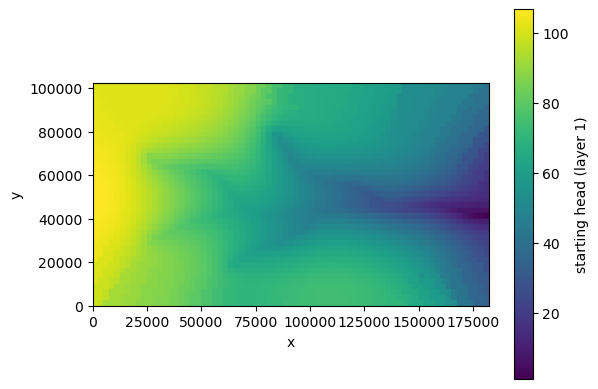

In [22]:
nc_ds["ic_strt_l1"].isel().ugrid.plot()
plt.gca().set_aspect(1.0)
plt.show(block=False)

# Deactivate NetCDF export and activate NetCDF import.

In [23]:
# update model for netcdf input
gwf.export_netcdf = None
gwf.nc_filerecord = "model.nc"

# Write the simulation and the overwrite the IC package to specify gridded arrays should be read from NetCDF.

In [24]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package model...
  writing model model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package river...
    writing package gwd...
    writing package oc...


In [25]:
with open(ws / "model.ic", "w") as f:
    f.write("BEGIN options\n")
    f.write("END options\n\n")
    f.write("BEGIN griddata\n")
    f.write("  strt NETCDF\n")
    f.write("END griddata\n\n")

# Run the simulation.

In [26]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../usgs/modflow6/bin/mf6
                               MODFLOW 6 EXTENDED
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 05/23/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Aug 27 2024 10:04:53 with GCC version 11.4.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
use o

(True, [])